# IV analyse of juxtacellular data
Data provided by Daniel English and Sam McKenzie

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import numpy as np
import quantities as pq
import seaborn as sns
import sys
sys.path.append('../exana/'),
from exana.stimulus import plot_psth
from exana.statistics.plot import plot_xcorr, plot_autocorr
from exana.statistics.tools import ccg_significance, correlogram
from method import IV

import scipy
import neo
import exana

import pdb

### Load files and convert to neo

In [2]:
ses = scipy.io.loadmat('../data/JuxtaGroundTruth.mat')

blks = []

for ses_i in ses['ses'][0]:
    sesi_dict = {'stimTimes': ses_i[0],
                 'name': ses_i[1],
                 'ID': ses_i[2],
                 'juxta_ID': ses_i[3],
                 'times': ses_i[4],
                 'rippleTimes': ses_i[5],}
    blk = neo.Block(name=sesi_dict['name'])
    
    seg = neo.Segment()
    chx_units = neo.ChannelIndex(index=0,
                                 name='units')
    blk.channel_indexes.append(chx_units)
    
    # load spike times
    
    unique_neuron_ids = np.unique(sesi_dict['ID'], axis=0)
    for neuron_id_i in unique_neuron_ids:
        unit_i = neo.Unit(name=str(list(neuron_id_i)),
                          electrode=neuron_id_i[0],
                          cluster=neuron_id_i[1])
        
        spkts_idcs = np.where((sesi_dict['ID']==neuron_id_i).all(axis=1))
        spkts = sesi_dict['times'][spkts_idcs]
        spkts = spkts.flatten()
        spk_train = neo.SpikeTrain(times=spkts,
                                   t_start=np.min(spkts),
                                   t_stop=np.max(spkts),
                                   units='s',
                                   name=str(neuron_id_i))
        spk_train.unit = unit_i
        seg.spiketrains.append(spk_train)
        unit_i.spiketrains.append(spk_train)
        chx_units.units.append(unit_i)
        
    # load stimulation epochs
    stim_start = sesi_dict['stimTimes'][:, 0]
    stim_dur = sesi_dict['stimTimes'][:, 1] - sesi_dict['stimTimes'][:, 0]
    
    epc = neo.Epoch(times=stim_start*pq.s,
                    durations=stim_dur*pq.s,
                    name='Stim',
                    description=sesi_dict['juxta_ID'])
    seg.epochs.append(epc)
    blk.segments.append(seg)
    blks.append(blk)

In [3]:
n_units = []
for i, blk in enumerate(blks):
    units = blk.channel_indexes[0]
    unit_names = [u.name for u in units.children]
    n_units_i = len(unit_names)
    n_units.append(n_units_i)
print('Number of units per session')
print(n_units)

Number of units per session
[6, 12, 18, 6, 25, 35, 31, 32, 37, 32, 25, 40, 32, 38, 25, 24, 14, 21]


## 1) PSTH
### Aim
Determine reasonable latencies for IV analyses.

### 1a) We start by looking at PSTHs of the first session


/opt/conda/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


['[1, 2]', '[1, 3]', '[1, 4]', '[1, 5]', '[1, 6]', '[1, 7]']


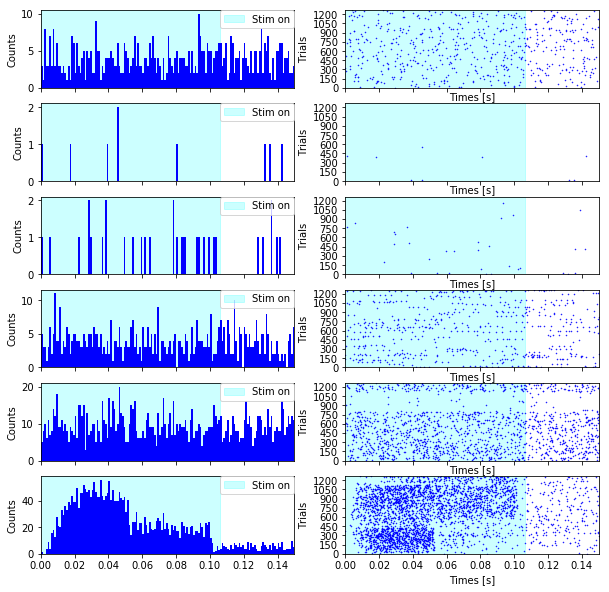

In [4]:
# start with a single example

blk = blks[0]
seg=blk.segments[0]
spktrns = seg.spiketrains
epc = seg.epochs[0]
xlim = [0, 150] * pq.ms


fig, axs = plt.subplots(len(spktrns),2,
                        sharex=True,
                        figsize=(10,10))
for i, spktrn_i in enumerate(spktrns):
    plot_psth(spike_train=spktrn_i,
              epoch=epc,
              xlim=xlim,
              axs=[axs[i, 0], axs[i, 1]],
              hist_binsize=1*pq.ms,
              stim_style='patch',
              stim_color='cyan',
              hist_alpha=1.,
              hist_edgecolor=None, 
              hist_ylabel='Counts',
              rast_size=1);
print([sptr_i.unit.name for sptr_i in spktrns])

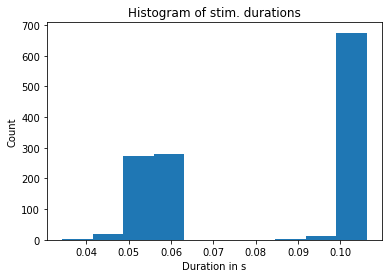

In [5]:
fig, ax = plt.subplots(1)
ax.hist(epc.durations.magnitude)
ax.set_title('Histogram of stim. durations')
ax.set_xlabel('Duration in ' + str(epc.durations.dimensionality))
ax.set_ylabel('Count')
plt.show()

### Observation
* Some with very low firing rate
* Some with relative high rate (maybe interneurons?)
* Stimulated cell (last row) has a relative slow onset, reaching peak firing rate after 20 ms.
* Stimulated cell seems to cease firing directly after stimulation onset

### Questions:
Not clear how to determine right latency values from those observations

## Approach: To determine the right latencies we look at different cross correlations.
* We choose a session with many neurons
* For the stimulated neuron we look at the distribution of stimulation onset and first spike after stimulation onset.
* We use classical cross correlation analysis to find pre- and postsynaptic partners.
* We look at the average latency of stimulation onset and postsynaptic cells.


## Does the last spike before stimulation predict the when the first spike after stimulation will happen?
For now we address the question only visually.

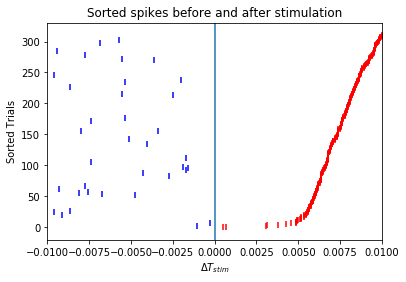

In [6]:
blk = blks[8]
seg=blk.segments[0]
units = blk.channel_indexes[0]
spktrns = seg.spiketrains
epc = seg.epochs[0]

juxta_id = list(epc.description[0])
unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
spktr_juxta = unit_juxta.spiketrains[0]

# We collect last spike before and first spike after stimulation onset

spks_bfr_aft = np.zeros((len(epc.times), 3))
# spks_bfr_aft, column 0 - last spike before onset,
# 1 - first spike after onset, 2 - stim onset 


for i, stim_t_i in enumerate(epc.times):
    idx = np.searchsorted(spktr_juxta.times, stim_t_i)
    spks_bfr_aft[i, 0] = spktr_juxta.times[idx-1]
    spks_bfr_aft[i, 1] = spktr_juxta.times[idx]
    spks_bfr_aft[i, 2] = stim_t_i

ltnc_onst = spks_bfr_aft[:, 1] - spks_bfr_aft[:, 2]
ltnc_prevspk = spks_bfr_aft[:, 0] - spks_bfr_aft[:, 2]

# look only at those values within short interval, {-dt, dt} with regard to stimulation
dt = 0.01

bool_onst = ltnc_onst<dt

ltnc_onst_lim = ltnc_onst[bool_onst]
ltnc_prevspk_lim = ltnc_prevspk[bool_onst]

argsrt_onst = np.argsort(ltnc_onst_lim)

fig, ax = plt.subplots(1)
ax.scatter(ltnc_onst_lim[argsrt_onst], range(len(ltnc_onst_lim)), marker='|',c='r')
ax.set_xlim([-0.01, 0.01])

ax.scatter(ltnc_prevspk_lim[argsrt_onst], range(len(ltnc_onst_lim)), marker='|',c='b')
ax.set_xlim([-0.01, 0.01])

ax.axvline(0)

ax.set_xlabel(r'$\Delta T_{stim}$')
ax.set_ylabel('Sorted Trials')

ax.set_title('Sorted spikes before and after stimulation')
plt.show()

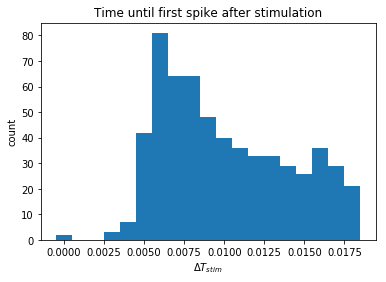

Peak at [s]: 0.006


In [7]:
H, bins = np.histogram(ltnc_onst, bins=np.arange(0., 0.02, 0.001))

fig, ax = plt.subplots(1)
ax.bar(bins[:-1], H, width=0.001)
ax.set_xlabel(r'$\Delta T_{stim}$')
ax.set_ylabel('count')
ax.set_title('Time until first spike after stimulation')

plt.show()

print('Peak at [s]: ' + str(np.round(bins[np.argmax(H)], 3)))

### Observation
Neuron reacts mostly after 5 ms.
Visible in both the plot with trials sorted by latency to stim and the histogram of time until first spike.

No obvious relation between post-stim. and pre.stim spike can be discovered

### interpretation
5 ms seems to be too long for any refractory effect from the prestimulation spike.

##  We plot the very same for the other data sets

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


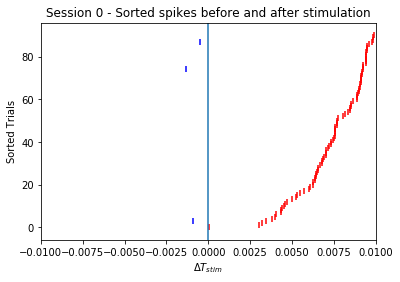

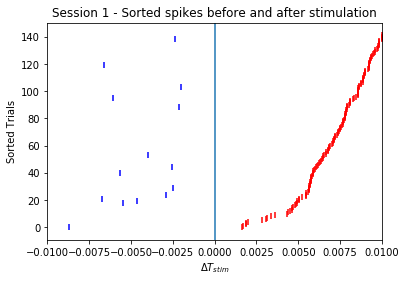

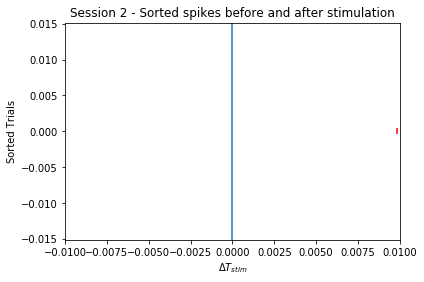

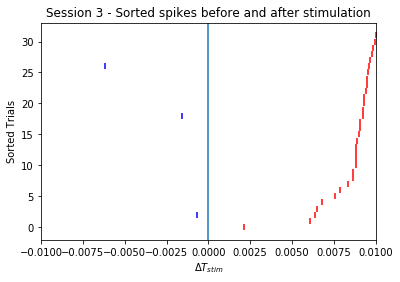

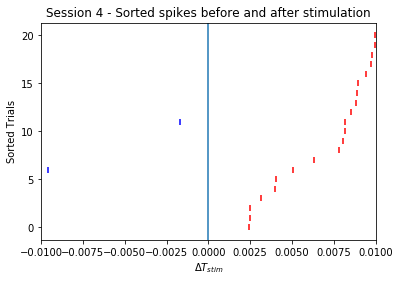

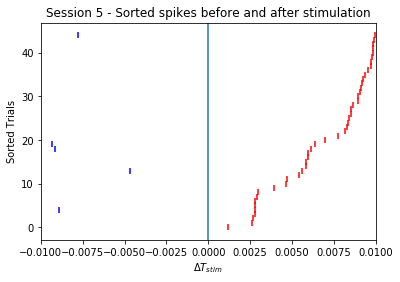

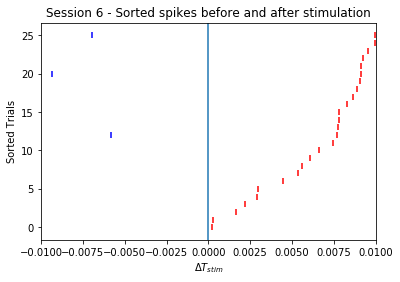

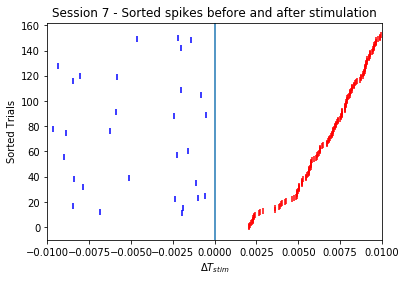

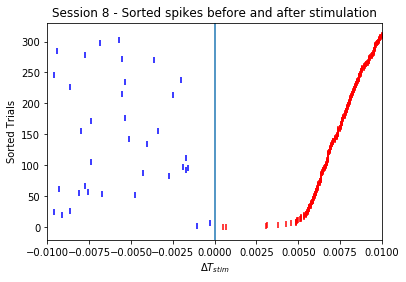

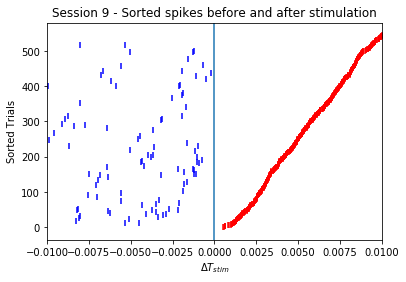

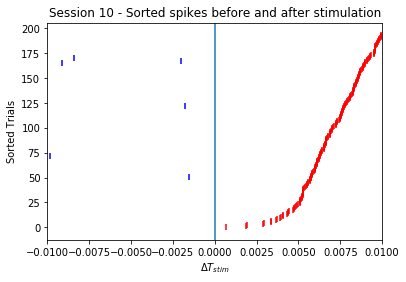

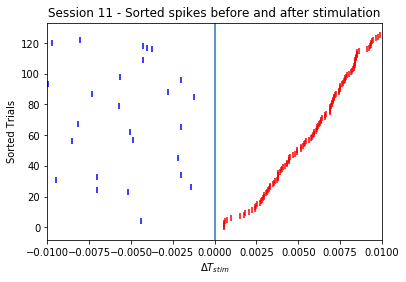

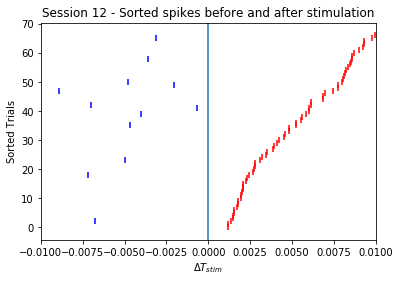

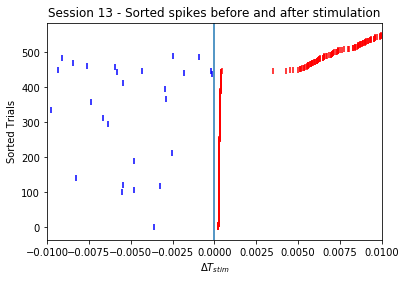

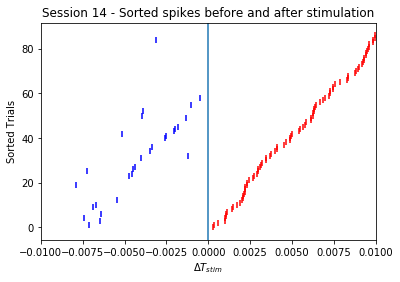

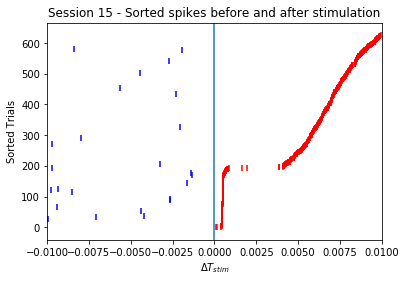

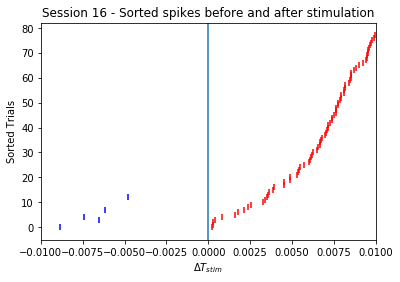

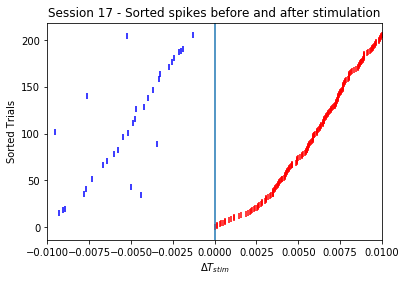

In [8]:
for k, blk in enumerate(blks):

    seg=blk.segments[0]
    units = blk.channel_indexes[0]
    spktrns = seg.spiketrains
    epc = seg.epochs[0]

    juxta_id = list(epc.description[0])
    unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
    spktr_juxta = unit_juxta.spiketrains[0]

    # We collect last spike before and first spike after stimulation onset

    spks_bfr_aft = np.zeros((len(epc.times), 3))
    # spks_bfr_aft, column 0 - last spike before onset,
    # 1 - first spike after onset, 2 - stim onset 


    for i, stim_t_i in enumerate(epc.times):
        idx = np.searchsorted(spktr_juxta.times, stim_t_i)
        if idx>=len(spktr_juxta.times):
            spks_bfr_aft[i, 1] = np.nan
        else:
            spks_bfr_aft[i, 1] = spktr_juxta.times[idx]
        spks_bfr_aft[i, 0] = spktr_juxta.times[idx-1]
        spks_bfr_aft[i, 2] = stim_t_i

    ltnc_onst = spks_bfr_aft[:, 1] - spks_bfr_aft[:, 2]
    ltnc_prevspk = spks_bfr_aft[:, 0] - spks_bfr_aft[:, 2]

    # look only at those values within short interval, {-dt, dt} with regard to stimulation
    dt = 0.01

    bool_onst = ltnc_onst<dt

    ltnc_onst_lim = ltnc_onst[bool_onst]
    ltnc_prevspk_lim = ltnc_prevspk[bool_onst]

    argsrt_onst = np.argsort(ltnc_onst_lim)

    fig, ax = plt.subplots(1)
    ax.scatter(ltnc_onst_lim[argsrt_onst], range(len(ltnc_onst_lim)), marker='|',c='r')
    ax.set_xlim([-0.01, 0.01])

    ax.scatter(ltnc_prevspk_lim[argsrt_onst], range(len(ltnc_onst_lim)), marker='|',c='b')
    ax.set_xlim([-0.01, 0.01])

    ax.axvline(0)

    ax.set_xlabel(r'$\Delta T_{stim}$')
    ax.set_ylabel('Sorted Trials')

    ax.set_title('Session ' + str(k) + ' - Sorted spikes before and after stimulation')
plt.show()

### Observation
There are some traces that indicate the effect we were hoping to see.
Spiking occurs immediately after the stimulation onset, only if it had not been directly preceded by a spike.
Indications of this effect are visible in session 1, 7, 9, 11, 12, 13, 15.

Session 14 and 17 need further investigation.
Maybe time between stimulations is very low.

## How long is refractory period?
### Approach
Autocorrelation

In [9]:
blk = blks[13]
seg=blk.segments[0]
units = blk.channel_indexes[0]
spktrns = seg.spiketrains
epc = seg.epochs[0]

juxta_id = list(epc.description[0])
unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
spktr_juxta = unit_juxta.spiketrains[0]

(0, 400)

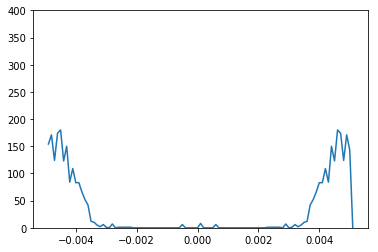

In [10]:
cnt, bins = correlogram(spktr_juxta, auto=True, limit=0.005*pq.s, binsize=0.0001*pq.s)

fig, ax = plt.subplots(1)
ax.plot(bins, cnt)
ax.set_ylim([0, 400])

### Observation
With the exception of a few spikes with very close in time, it appears that most spikes come after $\Delta t > 3 ms$

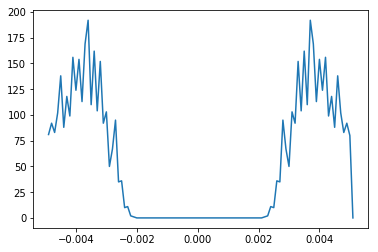

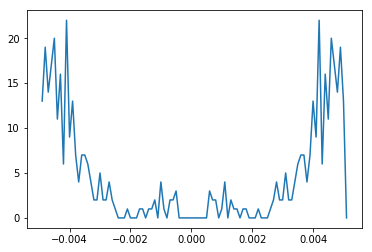

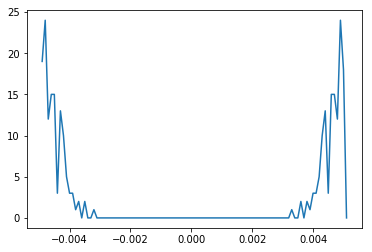

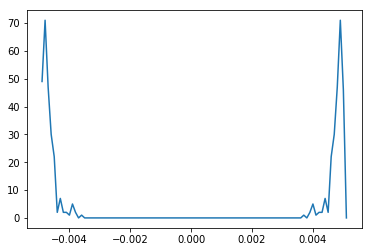

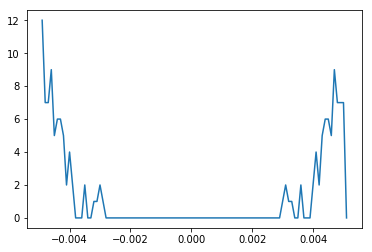

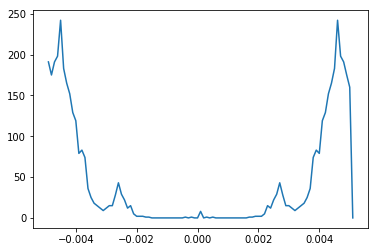

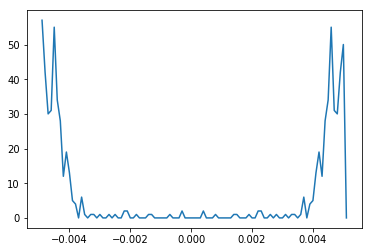

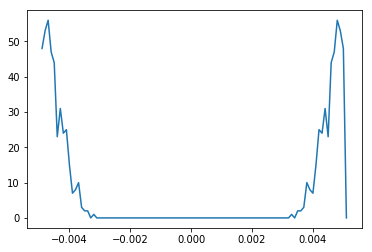

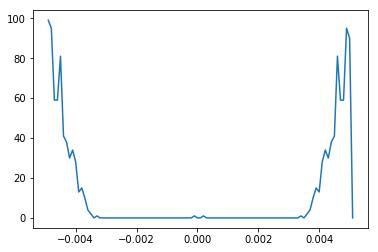

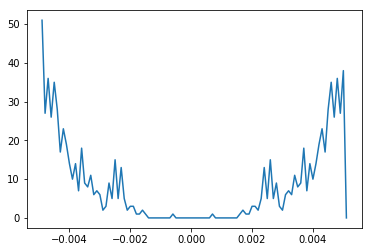

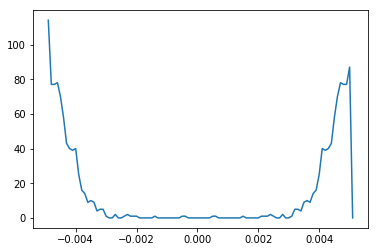

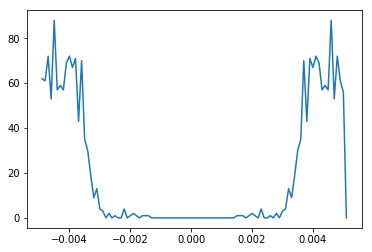

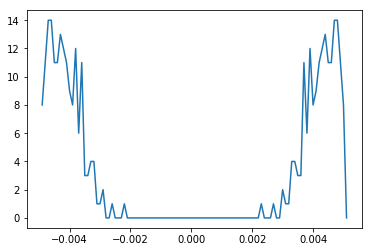

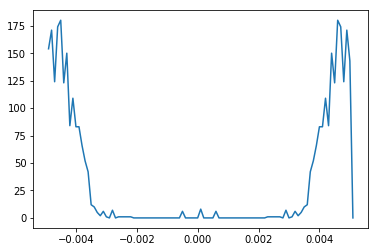

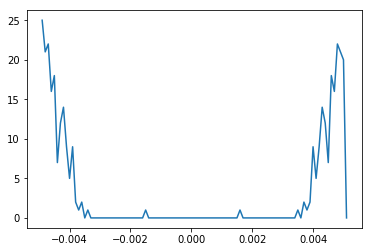

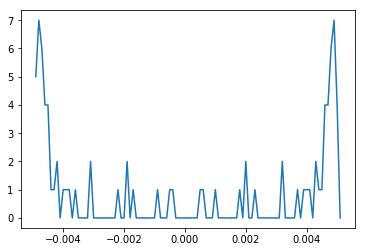

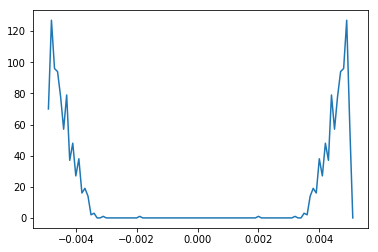

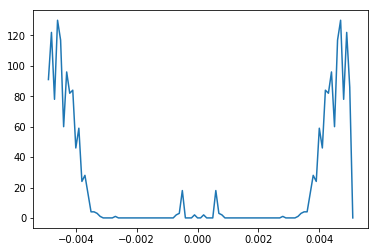

In [11]:
for k, blk in enumerate(blks):

    seg=blk.segments[0]
    units = blk.channel_indexes[0]
    spktrns = seg.spiketrains
    epc = seg.epochs[0]

    juxta_id = list(epc.description[0])
    unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
    spktr_juxta = unit_juxta.spiketrains[0]

    cnt, bins = correlogram(spktr_juxta, auto=True, limit=0.005*pq.s, binsize=0.0001*pq.s)

    fig, ax = plt.subplots(1)
    ax.plot(bins, cnt)
#    ax.set_ylim([0, 400])
plt.show()

### Observation
$t_{ref} \sim 3 ms$ holds generally

## Excluding the confounding effect of other neurons
The core idea of the IV approach is to distinguish between the direct causal connections between A -> C and the effect of a different confounding factor, B->C.
The inferred correlation A-C, could be confounded by B, which may also be activated by optogenetics.
The IV approach exploids the idea that A will be once in a while in a nonreceptive state, for example because of the refractory period.
If C responds, despite no activity from A, we know it must be due to some other confounding factor, B.

### Approach
We compare two Xcorr diagrams: The one of the stimulation onset to the first spike of the stimulated cell, and the other is the stimulation onset to the first spike of the postsynaptic cell.
If the postsynaptic cell also responds more likely to the stimulation, while the presynaptic cell is not firing, we assume that their is a confouding path.

### There should be no such effect in the juxtacellular case.
In the juxtacellular stimulation case we expect that only a single cell is stimulated.
We therefore expect that there is no other path connection Stim and C.
If A did not spike, C should also show no increased propensity to spike.

In [12]:
# Block 1
blk = blks[4]
seg=blk.segments[0]
units = blk.channel_indexes[0]
spktrns = seg.spiketrains
epc = seg.epochs[0]
juxta_id = list(epc.description[0])
print(juxta_id)
unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
spktr_juxta = unit_juxta.spiketrains[0]

#fig = plt.figure(figsize=(15,15))
#xcorr, fig = plot_xcorr(spktrns, fig=fig, acorr=False, time_limit=0.04*pq.s, binsize=0.002*pq.s)
#plt.show()

[1, 26]


In [13]:
#sel = '[1, 12]'
sel = '[1, 24]'  # ses 4
 
#sel = ['[1, 6]', '[1, 12]']
sig_level = 0.01

spktr_sel = [sptr_i for sptr_i in spktrns if sptr_i.unit.name == sel][0]

pcausal, pfast, bins, ccg, ccg_smoothed = ccg_significance(
    spktr_juxta,
    spktr_sel,
    binsize=0.0004*pq.s,
    limit=0.028*pq.s,
    hollow_fraction=0.6,
    width=0.01*pq.s)

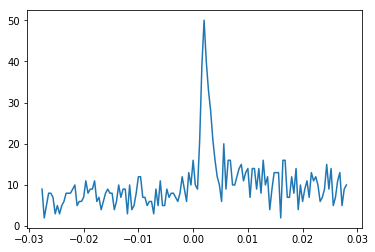

Peak at [s]: 0.002


In [14]:
plt.plot(bins, ccg)
plt.show()

print('Peak at [s]: ' + str(np.round(bins[np.argmax(ccg)],4)))

In [17]:
bool_cntctd = np.any(np.logical_and.reduce((pcausal < sig_level, pfast < sig_level, 0.0008<bins, bins<0.0028)))
print(str(juxta_id) + ' connected to ' + sel + ': ' + str(bool_cntctd))

[1, 26] connected to [1, 24]: True


In [22]:
mask = (bins > 0.0008) & (bins < 0.0028)
trans_prob = sum(ccg[mask] - ccg_smoothed[mask]) / len(spktr_sel)
print('Transition probability: ' + str(np.round(trans_prob, 3)))

Transition probability: 0.022


In [23]:
spks_bfr_aft = np.zeros((len(epc.times), 4), dtype=object)

# spks_bfr_aft, columns:
# 0 - first spike after onset,
# 1 - spikes in time window before and after stimulation, relative time
# 2 - spikes in time window of postsynaptic neuron
# 3 - stimulation times
dt = 0.05* pq.s
for i, stim_t_i in enumerate(epc.times):
    try:
        idx = np.searchsorted(spktr_juxta.times, stim_t_i)
        idx_start = np.searchsorted(spktr_juxta.times, stim_t_i-dt)
        idx_stop = np.searchsorted(spktr_juxta.times, stim_t_i+dt)
        spks_bfr_aft[i, 0] = spktr_juxta.times[idx]
        spks_bfr_aft[i, 1] = spktr_juxta.times[idx_start:idx_stop]-stim_t_i
        idx_post_start = np.searchsorted(spktr_sel.times, stim_t_i-dt)
        idx_post_stop = np.searchsorted(spktr_sel.times, stim_t_i+dt)    
        spks_bfr_aft[i, 2] = spktr_sel.times[idx_post_start:idx_post_stop]-stim_t_i
        spks_bfr_aft[i, 3] = stim_t_i
    except:
        pass

ltnc_onst = spks_bfr_aft[:, 0] - spks_bfr_aft[:, 3]
argsrt_onst = np.argsort(ltnc_onst)

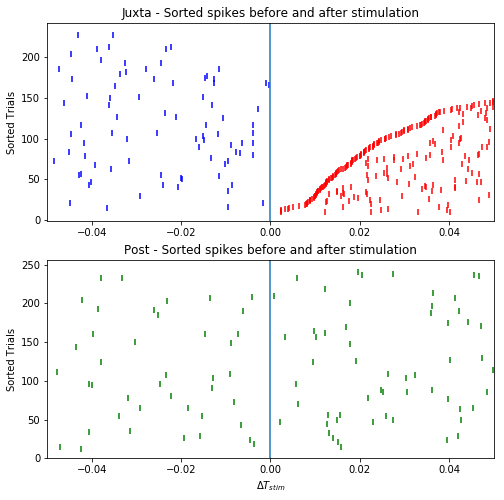

In [24]:
fig, ax = plt.subplots(2,1, figsize=(8,8))

n_trials = len(ltnc_onst)

for i, argsrt_i in enumerate(argsrt_onst):
    try:
        for j in spks_bfr_aft[argsrt_i, 1]:
            if j < 0:
                ax[0].scatter(j, i, marker='|',c='b')
            if j >= 0:
                ax[0].scatter(j, i, marker='|',c='r')
        for j in spks_bfr_aft[argsrt_i, 2]:
                ax[1].scatter(j, i, marker='|',c='g')  
    except:
        pass
ax[0].set_xlim([-dt, dt])
ax[1].set_xlim([-dt, dt])

#ax.scatter(spks_bfr_aft[argsrt_onst, 2], range(n_trials), marker='|',c='b')
#ax.set_xlim([-dt, dt])

ax[0].axvline(0)
ax[1].axvline(0)

ax[1].set_xlabel(r'$\Delta T_{stim}$')
ax[0].set_ylabel('Sorted Trials')
ax[1].set_ylabel('Sorted Trials')

ax[0].set_title('Juxta - Sorted spikes before and after stimulation')
ax[1].set_title('Post - Sorted spikes before and after stimulation')

plt.show()

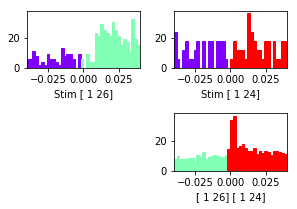

In [25]:
xcorr, fig = plot_xcorr([epc, spktr_juxta, spktr_sel], acorr=False, time_limit=0.04*pq.s, binsize=0.002*pq.s) 

### Simple method with only looking whether there was a response or not results in a dependence on the time window.

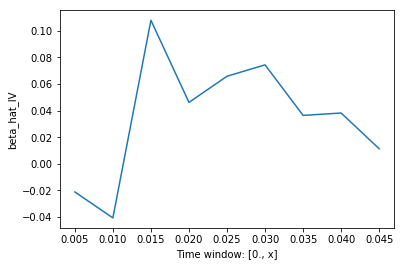

In [26]:
beta = []
ltnc_syn = 0.001
range_wndw = np.arange(0.005, 0.05, 0.005)
for i in range_wndw:
    iv = IV(spktr_juxta.times.magnitude,
            spktr_sel.times.magnitude,
            epc.times.magnitude, i, ltnc_syn)
    beta.append(iv.wald)

fig, ax = plt.subplots(1)
ax.plot(range_wndw, beta)
ax.set_ylabel('beta_hat_IV')
ax.set_xlabel('Time window: [0., x]')
plt.show()

### Visual verification: Xcorr between stim and postsyn. neuron, conditioned on whether presyn. fired.
#### Approach
Take correlogram of each stimulation snippet.
Average over correlograms, where at least one or no presynaptic spike was detected

#### Expectation
No peak when conditioning on those trials where there was no presynaptic spike, but peak otherwise.

In [27]:
dt = 0.02 * pq.s
binsize = 0.005 * pq.s

corr_s =  np.zeros(int(2*dt/binsize))
corr_sr =  np.zeros(int(2*dt/binsize))
cnt_s = 0.
cnt_sr = 0.

for i, stim_t_i in enumerate(epc.times):
    try:
        idx_start = np.searchsorted(spktr_juxta.times, stim_t_i)
        idx_stop = np.searchsorted(spktr_juxta.times, stim_t_i+dt)
        spks_pre = spktr_juxta.times[idx_start:idx_stop]
        idx_post_start = np.searchsorted(spktr_sel.times, stim_t_i-dt)
        idx_post_stop = np.searchsorted(spktr_sel.times, stim_t_i+dt)    
        spks_post = spktr_sel.times[idx_post_start:idx_post_stop]
        corr, bins = correlogram(np.array([(stim_t_i.magnitude)]),
                                 spks_post.magnitude,
                                 binsize=binsize.magnitude,
                                 limit=dt.magnitude)
        if np.any(spks_pre):
            corr_s = corr_s + corr
            cnt_s += 1.
        elif not np.any(spks_pre):
            corr_sr += corr
            cnt_sr += 1.
    except:
        pass
corr_s /= cnt_s
corr_sr /= cnt_sr

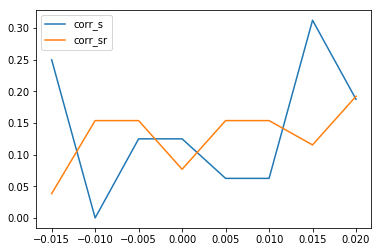

In [28]:
fig, ax = plt.subplots(1)
ax.plot(bins,corr_s, label='corr_s')
ax.plot(bins,corr_sr, label='corr_sr')
ax.legend()
plt.show()

#### Observation
Approach seems to reflect expectation, but low number of datapoints.

## Compare IV with spike transmission 
Go through each recording session.
Determine connected cells via CCH.
Compute for each pair spike transmission probability and IV estimate.

In [51]:
time_limit=0.04*pq.s
binsize=0.002*pq.s
peak_wndw = [0.0008, 0.0028]
ltnc_syn = 0.01 # in s
syn_strength = []
iv_window = 0.02 # in s

for k, blk in enumerate(blks):
    print(k)
    seg=blk.segments[0]
    units = blk.channel_indexes[0]
    spktrns = seg.spiketrains
    epc = seg.epochs[0]

    juxta_id = list(epc.description[0])
    unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
    spktr_juxta = unit_juxta.spiketrains[0]
    
    for spktr_i in spktrns:
        pcausal, pfast, bins, cch, cch_s = ccg_significance(
            spktr_juxta, spktr_i,
            limit=time_limit, binsize=binsize,
            hollow_fraction=0.6,
            width=0.01*pq.s)
        bool_cntctd = np.any(np.logical_and.reduce((pcausal < sig_level,
                                                    pfast < sig_level,
                                                    peak_wndw[0]<=bins,
                                                    bins<=peak_wndw[1])))
        if bool_cntctd:
            mask = (bins >= peak_wndw[0]) & (bins <= peak_wndw[1])
            trans_prob = np.sum(cch[mask] - cch_s[mask]) / len(spktr_juxta)
            try:   
                iv = IV(spktr_juxta.times.magnitude,
                        spktr_i.times.magnitude,
                        epc.times.magnitude,
                        iv_window, ltnc_syn)
            except:
                pdb.set_trace()
            syn_strength.append([trans_prob, iv.wald])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


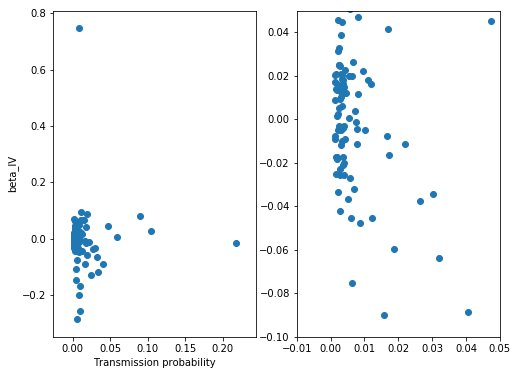

In [52]:
syn_strength = np.array(syn_strength)

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].scatter(syn_strength[:,0], syn_strength[:,1])
ax[0].set_xlabel('Transmission probability')
ax[0].set_ylabel('beta_IV')

ax[1].scatter(syn_strength[:,0], syn_strength[:,1])
ax[1].set_xlim([-0.01, 0.05])
ax[1].set_ylim([-0.1, 0.05])
plt.show()

In [42]:
plt.scatter?